In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
# CountVectorizer: builds dictionary of features and transforms documents to feature vectors
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import scipy
from scipy.sparse import vstack
import math
from scipy.special import factorial
from sklearn.linear_model import LogisticRegression
from warnings import filterwarnings

def data_process():
    twenty_train = fetch_20newsgroups(subset = "train", remove = ['headers', 'footers', 'quotes'])
    twenty_test = fetch_20newsgroups(subset = "test", remove = ['headers', 'footers', 'quotes'])
    twenty_train_df = pd.DataFrame({'data': twenty_train.data, 'target': twenty_train.target})
    twenty_test_df = pd.DataFrame({'data': twenty_test.data, 'target': twenty_test.target})

    #delete links and numbers in text
    twenty_train_df['data']=twenty_train_df['data'].apply(lambda x: re.sub('http://\S+|https://\S+|@\S+|[0-9]\S+','', str(x)))
    twenty_test_df['data']=twenty_test_df['data'].apply(lambda x: re.sub('http://\S+|https://\S+|@\S+|[0-9]\S+','', str(x)))

    #delete special characters from text
    twenty_train_df['data']=twenty_train_df['data'].apply(lambda x: re.sub('[^A-Za-z]+',' ', str(x)))
    twenty_test_df['data']=twenty_test_df['data'].apply(lambda x: re.sub('[^A-Za-z]+',' ', str(x)))

    return twenty_train, twenty_test, twenty_train_df, twenty_test_df

# Find and Plot the Class Distribution

In [57]:
def plot_class_distribution(twenty_train, twenty_test):
    # find number of targets for training and test set
    target, number = np.unique(twenty_train.target, return_counts=True)
    target_names = np.array(twenty_train.target_names)
    plt.bar(target_names, number, label="Training")

    target, number = np.unique(twenty_test.target, return_counts=True)
    target_names = np.array(twenty_test.target_names)
    plt.bar(target_names, number, label="Test")
    plt.xticks(rotation = 75)
    plt.title("20 Newsgroup Data Distribution")
    plt.xlabel("20 Newsgroup")
    plt.ylabel("Number")
    plt.legend()

# Naive Bayes Implementation

In [58]:
class NaiveBayes:
    
    def __init__(self):
        return
    
    def fit(self, x, y, alpha):
        #N: number of instance, D:number of feature
        N, D = x.shape
        #C: number of class
        C = np.max(y) + 1
        
        #one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        prior = np.zeros(C)
        likelihood = np.zeros((C, D))
        Nc = np.zeros(C)
        # 0.275 seems to be good gives accuracy of 0.660 with all features
        # for each class get the MLE for the mean and std
        for c in range(C):
            #slice all the elements from class c
            x_c = x[y == c] 
            #get number of elements of class c
            Nc[c] = x_c.shape[0]
            prior[c]=np.log(Nc[c]/ N)
            likelihood[c, :] = np.log((x_c.sum(axis=0) + alpha)/(x_c.sum(axis=1).sum(axis=0)+alpha*D))
            #mean of features of class c
            mu[c,:]= np.mean(x_c,0) 
            #sigma[c,:] = np.std(x_c, 0)   
            #std of features of class c
            x_c_temp = x_c.copy()
            x_c_temp.data **= 2
            variance=x_c_temp.mean(axis=0) - np.square(mu[c,:])
            sigma[c,:] = np.sqrt(variance)
 
        self.C=C
        self.prior = prior
        self.likelihood = likelihood
        self.mu = mu                                  
        self.sigma = sigma     
        #Laplace smoothing (using alpha_c=1 for all c)                        
        self.pi = (Nc+1)/(N+C)
        return self

def logsumexp(Z):                                                
    Zmax = np.max(Z,axis=0)[None,:]
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt, model_num = 0):
    # model_num 0: multinomial
    #           1: gaussian
    posterior = multinomial(self, xt)
    if model_num == 1:
        posterior = gaussian(self, xt)
    return posterior                                              

def gaussian(self, xt):
    Nt, D = xt.shape
    log_prior = np.log(self.pi)[:, None]
    #self.sigma[:,None,:]
    log_likelihood = -.5 * np.log(2*np.pi) - np.log(self.sigma[:,None,:]+1e-20) -.5 * ((xt[None,:,:] - self.mu[:,None,:])/(((self.sigma[:,None,:]+1e-20)**2)))
    # now we sum over the feature dimension to get a C x N matrix (this has the log-likelihood for each class-test point combination)
    log_likelihood = np.sum(log_likelihood, axis=2)
    # posterior calculation
    log_posterior = log_prior + log_likelihood
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return log_posterior.T

def multinomial(self, xt):
    log_posteriors = np.zeros((xt.shape[0],self.C))
    for i in range(xt.shape[0]):
        log_posteriors[i,:]=(((self.likelihood)*(xt[i,:].T)).sum(axis=1)).T+(self.prior).T
    return log_posteriors

NaiveBayes.predict = predict

def evaluate_acc(y_test, y_predict):
    accuracy = np.sum(y_predict == y_test)/y_predict.shape[0]
    return accuracy

def cross_validation_split(x_train_origin, y_train_origin, k_folds=5):
    index = np.arange(np.shape(x_train_origin)[0])
    np.random.shuffle(index)
    x_train_origin, y_train_origin = x_train_origin[index], y_train_origin[index]
    val_x=[]
    val_y=[]
    train_x=[]
    train_y=[]
    for i in range(k_folds):
        fold_len=x_train_origin.shape[0]//k_folds + 1 # + 1 to make the matrix the same shape with np.array_split method
        val_x.append(x_train_origin[i*fold_len:fold_len*(i+1)])
        train_x1 = x_train_origin[0*fold_len:i*fold_len]
        train_x2 = x_train_origin[fold_len*(i+1):]
        train_x.append(vstack([train_x1, train_x2]))

        split_y = np.array_split(y_train_origin, k_folds)
        val_y.append(split_y.pop(i))
        train_y.append(np.concatenate(split_y))
    return val_x, val_y, train_x, train_y

def kfoldCV(x_valid, y_valid, x_train, y_train, model, alpha, model_num):
    accuracy_list=[]
    for s in range(len(x_valid)):
        model.fit(x_train[s], y_train[s], alpha)
        y_prob = model.predict(scipy.sparse.csr_matrix.toarray(x_valid[s]), model_num)
        y_pred = np.argmax(y_prob, 1)
        accuracy_list.append(evaluate_acc(y_valid[s], y_pred))
    acc = sum(accuracy_list)/len(accuracy_list)
    print(accuracy_list)
    print(f'test accuracy: {acc}')
    return acc

# Naive Bayes 5-Fold Cross Validation for Best Parameters

In [59]:

def cv_max_feature(twenty_train_df):
    model = NaiveBayes()
    accuracy_multinomial=[]
    num_feature=[10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000]
    for i in num_feature:
        print(i)
        count_vect1 = CountVectorizer(stop_words='english', max_features=i)
        train_feature_count1 = count_vect1.fit_transform(twenty_train_df.data)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_count1, twenty_train_df.target, 5)
        accuracy_multinomial.append(kfoldCV(x_valid, y_valid, x_train, y_train, model, 0.5, 0)) # 0 indicate using Multinomial NB

    accuracy_gaussian=[]
    for i in num_feature:
        print(i)
        tfidf_vect = TfidfVectorizer(stop_words='english', max_features=i)
        train_feature_tfidf = tfidf_vect.fit_transform(twenty_train_df.data)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_tfidf, twenty_train_df.target, 5)
        accuracy_gaussian.append(kfoldCV(x_valid, y_valid, x_train, y_train, model, 0.5, 1)) # 1 indicate using Gaussian NB
    plt.plot(num_feature, accuracy_multinomial, label="Multinomial Naive Bayes")
    plt.plot(num_feature, accuracy_gaussian, label="Gaussian Naive Bayes")
    plt.title('Plot of models with different # features in 5 fold cross-validation')
    plt.xlabel('number of features')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()


def cv_min_df(twenty_train_df):
    model = NaiveBayes()
    min_df=[]
    accuracy_multinomial=[]
    for i in range(0,18,2):
        print(i)
        min_df.append(i)
        count_vect1 = CountVectorizer(stop_words='english', max_features=45000, min_df=i)
        train_feature_count1 = count_vect1.fit_transform(twenty_train_df.data)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_count1, twenty_train_df.target, 5)
        accuracy_multinomial.append(kfoldCV(x_valid, y_valid, x_train, y_train, model, 0.5, 0))

    accuracy_gaussian=[]
    for i in range(0,18,2):
        print(i)
        tfidf_vect = TfidfVectorizer(stop_words='english', max_features=10000, min_df=i)
        train_feature_tfidf = tfidf_vect.fit_transform(twenty_train_df.data)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_tfidf, twenty_train_df.target, 5)
        accuracy_gaussian.append(kfoldCV(x_valid, y_valid, x_train, y_train, model, 0.5, 1)) # 1 indicate using Gaussian NB
    
    plt.plot(min_df, accuracy_multinomial, label="Multinomial Naive Bayes")
    plt.plot(min_df, accuracy_gaussian, label="Gaussian Naive Bayes")
    plt.title('Plot of models with different min_df in 5 fold cross-validation')
    plt.xlabel('min_df')
    plt.ylabel('accuracy')
    #plt.xticks(range(0,30,2))
    plt.legend()
    plt.show()

def cv_max_df(twenty_train_df):
    model = NaiveBayes()
    max_df=[]
    accuracy_multinomial=[] 
    # max_df = 0.1 means ignore the words occur in more than 10% of the documents
    for i in range(10,65,5):
        i = i/100
        print(i)
        max_df.append(i)
        count_vect1 = CountVectorizer(stop_words='english', max_features=45000, min_df=1, max_df=i)
        train_feature_count1 = count_vect1.fit_transform(twenty_train_df.data)
        # split the test set into 5 folds
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_count1, twenty_train_df.target, 5)
        accuracy_multinomial.append(kfoldCV(x_valid, y_valid, x_train, y_train, model, 0.5, 0)) # 0 indicate using Multinomial NB

    accuracy_gaussian=[]
    for i in range(10,65,5):
        i = i/100
        print(i)
        tfidf_vect = TfidfVectorizer(stop_words='english', max_features=10000, min_df=4, max_df=i)
        train_feature_tfidf = tfidf_vect.fit_transform(twenty_train_df.data)
        # split the test set into 5 folds
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_tfidf, twenty_train_df.target, 5)
        # using 5-fold cross validation to find accuracy on validation set
        accuracy_gaussian.append(kfoldCV(x_valid, y_valid, x_train, y_train, model, 0.5, 1)) # 1 indicate using Gaussian NB
    
    plt.plot(max_df, accuracy_multinomial, label="Multinomial Naive Bayes")
    plt.plot(max_df, accuracy_gaussian, label="Gaussian Naive Bayes")
    plt.title('Plot of models with different max_df in 5 fold cross-validation')
    plt.xlabel('max_df')
    plt.ylabel('accuracy')
    #plt.xticks(range(0,30,2))
    plt.legend()
    plt.show()

def cv_alpha(twenty_train_df):
    model = NaiveBayes()
    alpha=[]
    accuracy_multinomial=[]
    for i in range(10,50,5):
        i = i/100
        print(i)
        alpha.append(i)
        count_vect1 = CountVectorizer(stop_words='english', max_features=45000, min_df=1, max_df = 0.3)
        train_feature_count1 = count_vect1.fit_transform(twenty_train_df.data)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_count1, twenty_train_df.target, 5)
        accuracy_multinomial.append(kfoldCV(x_valid, y_valid, x_train, y_train, model, i, 0)) # 0 indicate using Multinomial NB

    accuracy_gaussian=[]
    for i in range(10, 50,5):
        i = i/100
        print(i)
        tfidf_vect = TfidfVectorizer(stop_words='english', max_features=10000, min_df=1, max_df=0.3)
        train_feature_tfidf = tfidf_vect.fit_transform(twenty_train_df.data)
        x_valid, y_valid, x_train, y_train = cross_validation_split(train_feature_tfidf, twenty_train_df.target, 5)
        accuracy_gaussian.append(kfoldCV(x_valid, y_valid, x_train, y_train, model, i, 1)) # 1 indicate using Gaussian NB
   
    plt.plot(alpha, accuracy_multinomial, label="Multinomial Naive Bayes")
    plt.plot(alpha, accuracy_gaussian, label="Gaussian Naive Bayes")
    plt.title('Plot of models with different alpha in 5 fold cross-validation')
    plt.xlabel('alpha')
    plt.ylabel('accuracy')
    #plt.xticks(range(0,30,2))
    plt.legend()
    plt.show()


# Logistic Regression 5-fold Cross-validation for Best Parameters

In [60]:
#count_vect1 = CountVectorizer(stop_words='english')
#train_feature_count = count_vect1.fit_transform(twenty_train_df.data)
def cv_max_iter():
    filterwarnings('ignore')
    iteration=[]
    accuracy=[]
    for i in range(100,1000,300):
        print(i)
        iteration.append(i)
        a=[]
        count_vect1 = CountVectorizer(stop_words='english', max_features=60000)
        train_feature_count = count_vect1.fit_transform(twenty_train_df.data)
        test_feature_count = count_vect1.transform(twenty_test_df.data)
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, twenty_train_df.target, 5)
        for s in range(len(x_valid1)):
            clf = LogisticRegression(max_iter=i).fit(x_train1[s], y_train1[s])
            y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(x_valid1[s]))
            acc = evaluate_acc(y_valid1[s], y_prob)
            a.append(acc)
        print(sum(a)/len(a))
        accuracy.append(sum(a)/len(a))

    plt.plot(iteration, accuracy, label="Logistic Regression")
    plt.title('Plot of softmax models with different max iterations in 5 fold cross-validation')
    plt.xlabel('number of iterations')
    plt.ylabel('accuracy')
    plt.xticks(range(0,50,2))
    plt.legend()
    plt.show()
    
def cv_C():
    filterwarnings('ignore')
    c=[]
    accuracy=[]
    for i in range(1,100,5):
        print(i/100)
        c.append(i/100)
        a=[]
        count_vect1 = CountVectorizer(stop_words='english', max_features=60000)
        train_feature_count = count_vect1.fit_transform(twenty_train_df.data)
        test_feature_count = count_vect1.transform(twenty_test_df.data)
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, twenty_train_df.target, 5)
        for s in range(len(x_valid1)):
            clf = LogisticRegression(max_iter=18,C=i/100).fit(x_train1[s], y_train1[s])
            y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(x_valid1[s]))
            acc = evaluate_acc(y_valid1[s], y_prob)
            a.append(acc)
        print(sum(a)/len(a))
        accuracy.append(sum(a)/len(a))

    plt.plot(c, accuracy, label="Logistic Regression")
    plt.title('Plot of softmax models with different C in 5 fold cross-validation')
    plt.xlabel('C - Inverse of regularization strength')
    plt.ylabel('accuracy')
    #plt.xticks(range(0,1,0.1))
    plt.legend()
    plt.show()

def cv_penalty():
    filterwarnings('ignore')
    penalty=['none','l2']
    accuracy=[]
    for i in penalty:
        print(f'the norm of the penalty: {i}')
        a=[]
        count_vect1 = CountVectorizer(stop_words='english', max_features=60000)
        train_feature_count = count_vect1.fit_transform(twenty_train_df.data)
        test_feature_count = count_vect1.transform(twenty_test_df.data)
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, twenty_train_df.target, 5)
        for s in range(len(x_valid1)):
            clf = LogisticRegression(max_iter=18,C=0.61,penalty=i).fit(x_train1[s], y_train1[s])
            y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(x_valid1[s]))
            acc = evaluate_acc(y_valid1[s], y_prob)
            a.append(acc)
        accuracy=sum(a)/len(a)
        print(f'test accuracy: {accuracy}')

def cv_features():
    num_feature=[10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000]
    filterwarnings('ignore')
    iteration=[]
    accuracy=[]

    for i in num_feature:
        print(i)
        iteration.append(i)
        a=[]
        count_vect1 = CountVectorizer(stop_words='english', max_features=i)
        train_feature_count = count_vect1.fit_transform(twenty_train_df.data)
        test_feature_count = count_vect1.transform(twenty_test_df.data)
        x_valid1, y_valid1, x_train1, y_train1 = cross_validation_split(train_feature_count, twenty_train_df.target, 5)
        for s in range(len(x_valid1)):
            clf = LogisticRegression(max_iter=18, C=0.61).fit(x_train1[s], y_train1[s])
            y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(x_valid1[s]))
            acc = evaluate_acc(y_valid1[s], y_prob)
            a.append(acc)
        print(sum(a)/len(a))
        accuracy.append(sum(a)/len(a))

    plt.plot(iteration, accuracy, label="Logistic Regression")
    plt.title('Plot of softmax models with different number of features in 5 fold cross-validation')
    plt.xlabel('number of features')
    plt.ylabel('accuracy')
    #plt.xticks(range(0,50,2))
    plt.legend()
    plt.show()

# Find Accuracy on Test Set with Optimized Hyperparameters

In [61]:
def find_best():
    twenty_train, twenty_test, twenty_train_df, twenty_test_df = data_process()
    # for Multinomial Naive Bayes
    count_vect = CountVectorizer(stop_words = 'english', max_df = 0.3, min_df = 2)
    x_train_counts = count_vect.fit_transform(twenty_train_df.data)
    x_test_counts = count_vect.transform(twenty_test_df.data)
    y_train = twenty_train.target
    y_test = twenty_test.target

    model = NaiveBayes()
    model.fit(x_train_counts, y_train, 0.2)
    y_prob = model.predict(scipy.sparse.csr_matrix.toarray(x_test_counts), 0)
    y_pred = np.argmax(y_prob, 1)
    acc = evaluate_acc(y_test, y_pred)
    print(f'Multinomial NB test accuracy: {acc}')

    # for Logistric regresssion
    count_vect = CountVectorizer(stop_words = 'english', max_features = 45000, max_df = 0.3, min_df = 2)
    x_train_counts = count_vect.fit_transform(twenty_train_df.data)
    x_test_counts = count_vect.transform(twenty_test_df.data)
    y_train = twenty_train.target
    y_test = twenty_test.target

    clf = LogisticRegression(max_iter=18, C=0.61, penalty='l2').fit(x_train_counts, y_train)
    y_prob = clf.predict(scipy.sparse.csr_matrix.toarray(x_test_counts))
    acc = evaluate_acc(y_test, y_prob)
    print(f'Logistic Regression best test accuracy: {acc}')


# Main Method

Multinomial NB test accuracy: 0.6540095592140202
Logistic Regression best test accuracy: 0.6370154009559214


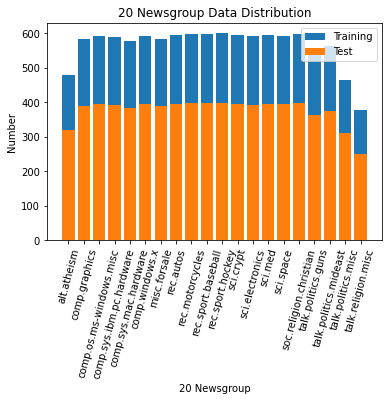

In [62]:
def main():
    twenty_train, twenty_test, twenty_train_df, twenty_test_df = data_process()
    plot_class_distribution(twenty_train, twenty_test)
    # 5-fold cross validation for Multinomial and Gaussian Naive Bayes
    #cv_max_feature(twenty_train_df)
    #cv_min_df(twenty_train_df)
    #cv_max_df(twenty_train_df)
    #cv_alpha(twenty_train_df)
    # 5-fold cross validation for Softmax regression
    #cv_max_iter()
    #cv_C()
    #cv_penalty()
    #cv_features()
    find_best()
main()